In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time 
import csv
import os
from pprint import pprint
from pandas.io.json import json_normalize

In [3]:
# import csv file that is a breakdown of cases and deaths per day by state and county
df = pd.read_csv("CSV Folder/us-counties.csv.txt")

#group by state and date so that data is no longer at the county level, but at the state level
state_df = df.groupby(["state","date"])

#Create a data frame that has total cases by date by state
cases = state_df["cases"].sum()
workable_df = pd.DataFrame(cases)
workable_df = workable_df.reset_index()

#get the data for deaths per state per day into a series format to add to the cases dataframe
deaths = state_df["deaths"].sum()
death=pd.DataFrame(deaths)
work_death=death.reset_index()
DEAD = work_death["deaths"]

# Add Deaths column to the cases dataframe
workable_df["Deaths"]=DEAD

#Create final dataframe with just the columns we are interested in
final_df = workable_df[["date","state","cases","Deaths"]]

#Sort final df by date and re-index
final_df = final_df.sort_values("date")
final_df = final_df.reset_index(drop = True)


In [4]:
#Liz's Hospital Dataframe



#read in .csv file
hospital_data = pd.read_csv("CSV Folder/hospitals.csv")

#set index to state_name
hospital_data.set_index("state_name",inplace=True)

#group dataframe by state_name
hg = hospital_data.groupby('state_name')

#do count of hg dataframe (where it groups by states)to get total count of hospitals, doctors, staff,
#icu beds, and icu beds utilized. Then add each series to new dataframe called 'state_hospital_data'

hg["num_icu_be"].count()
state_hospital_data = pd.DataFrame(hg["num_icu_be"].count())

hospitals = hg["hospital_n"].count()
state_hospital_data["Number of Hospitals"]=hospitals

doctors = hg["num_licens"].count()
state_hospital_data["Number of Doctors"]=doctors

staff = hg["num_staffe"].count()
state_hospital_data["Number of Staff"]=staff

icu_beds = hg["num_icu_be"].count()
state_hospital_data["ICU Beds Available"]=icu_beds

bed_utiliz = hg["bed_utiliz"].count()
state_hospital_data["ICU Beds Utilized"]=bed_utiliz

#drop double num_icu_be column
state_hospital_data.drop("num_icu_be",axis=1, inplace = True)



In [5]:
# reaching out to API to get current overall state data pertaining to cases, tests, hospitalizations, and deaths
url3 = "https://covidtracking.com/api/states"
response3 = requests.get(url3)
#Turned entire response into a dataframe
US_df = json_normalize(response3.json(), errors='ignore')
#Narrowed df to specific columns of interest 
US_df = US_df.iloc[:,[0,1,8,9,22,16,10,19]]

#Read in a State Name Abbrev CSV so that df's could be joined with different state naming conventions
st_abrev = pd.read_csv("CSV Folder/Covid Analysis Data - StateNameAbrev.csv")

# Replacing the state abbreviation with names for joining to other data
tests_df = st_abrev.merge(US_df, how = 'inner',left_on = "Abbreviation",right_on = "state")

#Droping abbreviation column since no other dataset used abbrev.
tests_df.drop(columns = ["Abbreviation","state"],inplace = True)

#Joined hospital information with the general information
comb1_df= tests_df.merge(state_hospital_data,how = 'inner',left_on = "State",right_on = "state_name")
#comb1_df.drop(columns = "state_name", inplace = True)

#Read in file about rankings of aggressive measures limiting the virus spread
States_Most_Aggressive_Measures_df = pd.read_csv("CSV Folder/States with the Most Aggressive Measures in Limiting Virus Exposure.csv", encoding ='latin-1')

#Joined rankings data
comb2_df = comb1_df.merge(States_Most_Aggressive_Measures_df, how = 'inner', on = 'State' )

#Renamed Column Headers
comb2_df.rename(columns = {"positive":"Positive",
                           "negative":"Negative",
                           "pending":"Pending",
                           "totalTestResults": "Total Tested",
                           "recovered": "Recovered",
                           "hospitalizedCurrently":"Currently Hospitalized",
                           "death": "Total Deaths",
                           "num_icu_be":"ICU Beds",
                           "Prevention & Containment Rank": "Prevention & Containment Rank",
                           "Risk Factors & Infrastructure Rank": "Risk Factors & Infrastructure Rank",
                           "Economic Impact Rank": "Economic Impact Rank"}, inplace = True)

C:\Users\walsh\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


In [6]:
comb2_df.head()

,State,Positive,Negative,Pending,Total Tested,Recovered,Currently Hospitalized,Total Deaths,Number of Hospitals,Number of Doctors,Number of Staff,ICU Beds Available,ICU Beds Utilized,Overall Rank,Prevention & Containment Rank,Risk Factors & Infrastructure Rank,Economic Impact Rank,Delta in Overall Rank vs. March 23
0,Alabama,5654,43295,NaN,48949,NaN,NaN,203.0,120,120,120,66,109,48,48,45,2,-15
1,Alaska,335,11824,NaN,12159,196.0,39.0,9.0,28,28,28,7,23,3,2,11,40,11
2,Arizona,5459,51142,NaN,56601,1265.0,664.0,229.0,126,126,126,46,108,39,36,46,19,-1
3,Arkansas,2438,29125,NaN,31563,898.0,97.0,44.0,106,106,106,40,100,46,45,49,5,1
4,California,35396,429931,NaN,465327,NaN,4984.0,1354.0,466,466,466,302,401,18,15,44,16,-17


In [7]:
#Sequoyah made a new column called Total beds, by adding ICU Beds Available and ICU Beds Utilized
comb2_df.dtypes
sum_beds = comb2_df["ICU Beds Available"] + comb2_df["ICU Beds Utilized"]
comb2_df["Total Beds"] = sum_beds
print(comb2_df)






             State  Positive  Negative  Pending  Total Tested  Recovered  \
0          Alabama      5654     43295      NaN         48949        NaN   
1           Alaska       335     11824      NaN         12159      196.0   
2          Arizona      5459     51142      NaN         56601     1265.0   
3         Arkansas      2438     29125      NaN         31563      898.0   
4       California     35396    429931      NaN        465327        NaN   
5         Colorado     10878     39767      NaN         50645        NaN   
6      Connecticut     22469     47449      NaN         69918        NaN   
7         Delaware      3200     13353      NaN         16553      599.0   
8          Florida     28309    260318   1258.0        288627        NaN   
9          Georgia     21102     73332      NaN         94434        NaN   
10          Hawaii       592     25536      NaN         26128      444.0   
11           Idaho      1802     16290      NaN         18092      767.0   
12        Il

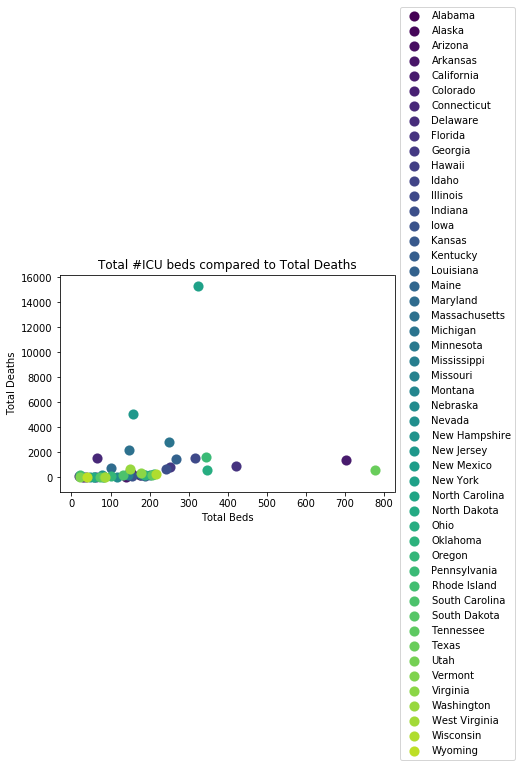

In [8]:
#Sequoyah's Scatter plot
import matplotlib.cm as cm
import matplotlib.colors as colors


fig, ax = plt.subplots()



colormap = cm.viridis
colorlist = [colors.rgb2hex(colormap(i)) for i in np.linspace(0, 0.9, len(comb2_df['State']))]

for i,c in enumerate(colorlist):

    x = comb2_df['Total Beds'][i]
    y = comb2_df['Total Deaths'][i]
    l = comb2_df['State'][i]

    ax.scatter(x , y , label=l, s=100, linewidth=0.1, c=c)      


ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
ax.set_title('Total #ICU beds compared to Total Deaths')
ax.set_xlabel('Total Beds')
ax.set_ylabel('Total Deaths')

plt.savefig("PNG Folder/Total #ICU beds compared to Total Deaths.png") 
plt.show()

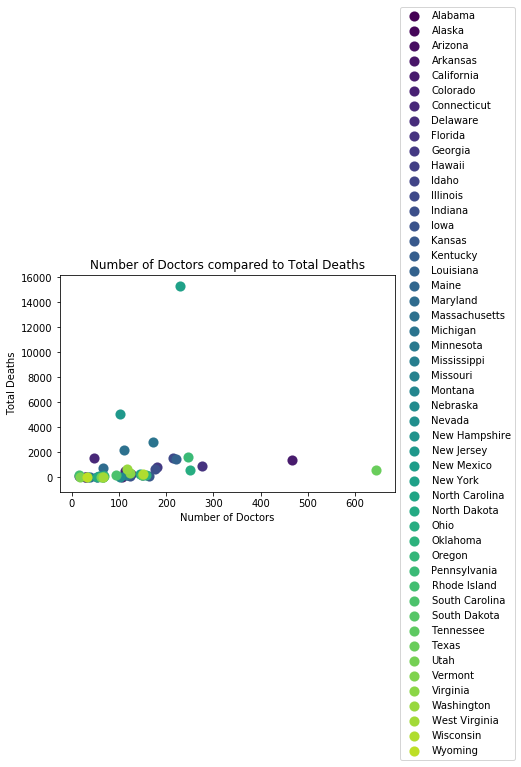

In [9]:
#Sequoyah's Scatter plot
fig, ax1 = plt.subplots()



colormap = cm.viridis
colorlist = [colors.rgb2hex(colormap(i)) for i in np.linspace(0, 0.9, len(comb2_df['State']))]

for i,c in enumerate(colorlist):

    x = comb2_df['Number of Doctors'][i]
    y = comb2_df['Total Deaths'][i]
    l = comb2_df['State'][i]

    ax1.scatter(x , y , label=l, s=100, linewidth=0.1, c=c)      


ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
ax1.set_title('Number of Doctors compared to Total Deaths')
ax1.set_xlabel('Number of Doctors')
ax1.set_ylabel('Total Deaths')

plt.savefig("PNG Folder/Number of Doctors compared to Total Deaths.png") 
plt.show()

C:\Users\walsh\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


826692
826692
97162
 Total deaths in us is 826692 and the percent of states with less than 1% is 11.75


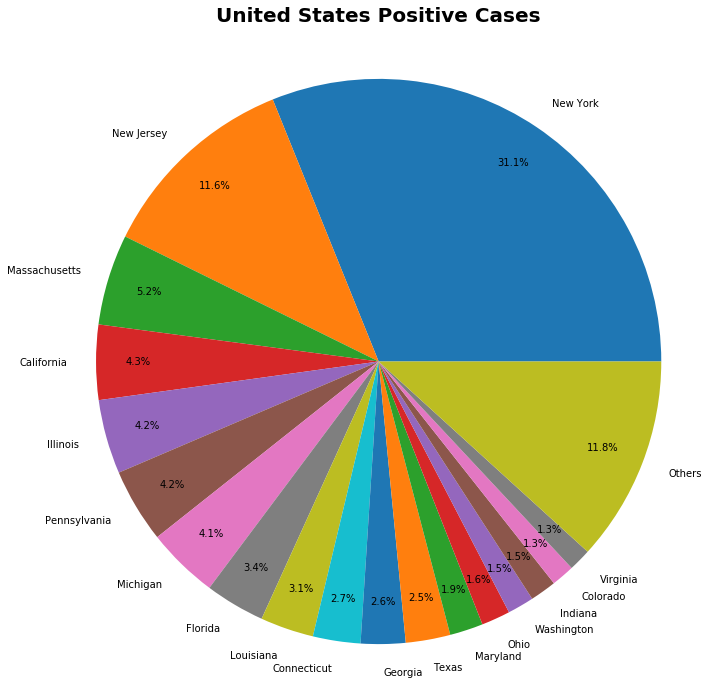

In [13]:
#comb2_df.sort_values("Positive", ascending = False,inplace = True)
comb2_df["Percent of Cases in US"]=round(comb2_df["Positive"]/comb2_df["Positive"].sum()*100,2)
comb2_df.reset_index(drop = True)
CasesbyStatePie = comb2_df[comb2_df["Percent of Cases in US"]>1]
CasesbyStatePie.sort_values("Positive", inplace = True, ascending = False)
USCases = comb2_df["Positive"].sum()
PercentTop = CasesbyStatePie["Percent of Cases in US"].sum()
PercentOther = (100 - float(PercentTop))
OtherCases = USCases - CasesbyStatePie["Positive"].sum()
print(comb2_df["Positive"].sum())
print(USCases)
print(OtherCases)
print(f" Total deaths in us is {USCases} and the percent of states with less than 1% is {PercentOther}")
Chart = CasesbyStatePie.append({"State":"Others","Positive":OtherCases,"Percent of Cases in US":PercentOther}, ignore_index = True)
Chart




#Sequoyah's Pie Chart 
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie(Chart['Positive'], labels=Chart['State'], shadow=False, pctdistance=0.85, 
         autopct='%1.1f%%')


plt.axis('equal')

plt.title("United States Positive Cases",fontdict ={'fontsize': 20,
        'fontweight' : 700})# View the plot
plt.tight_layout()

plt.savefig("PNG Folder/United States Positive Cases.png") 


plt.show()

In [10]:
#Sequoyah's Code 

Increase_in_Unemployment_df = pd.read_csv("CSV Folder/States with the Biggest Increases in Unemployment Due to Coronavirus.csv")


Increase_in_Unemployment_df

,,,<<<<<<< HEAD
Overall Rank,State,Increase in Unemployment Claims (2020 vs. 2019)*,Increase in Unemployment Claims (April vs. Jan...
24,Alabama,3552.96%,2109.81%
46,Alaska,1625.03%,1466.77%
12,Arizona,2528.53%,4120.59%
30,Arkansas,2610.76%,2267.70%
...,...,...,...
36,Washington,2707.22%,1664.04%
47,West Virginia,1986.28%,804.41%
48,Wisconsin,1847.15%,715.12%
49,Wyoming,1324.42%,640.18%


In [11]:
df = pd.read_csv("CSV Folder/Poverty by state 2018.csv")
df.rename( columns={'Unnamed: 0':'State'}, inplace=True )
df.head()

,State,Percent in Poverty (All),90% CI Lower,90%CI Upper,Children ages 0-17 in Poverty,90% CI Lower.1,90%CI Upper.1
0,Alabama,16.8,16.5,17.1,23.9,23.2,24.6
1,Alaska,11.1,10.5,11.7,14.5,13.4,15.6
2,Arizona,14.1,13.8,14.4,20.4,19.7,21.1
3,Arkansas,16.8,16.3,17.3,23.8,22.8,24.8
4,California,12.8,12.7,12.9,17.4,17.1,17.7


In [12]:
pop_df = pd.read_csv("CSV Folder/SCPRC-EST2019-18+POP-RES.csv")
pop_df= pop_df[["NAME", "POPESTIMATE2019","POPEST18PLUS2019","PCNT_POPEST18PLUS"]]
pop_df = pop_df.rename(columns = {"NAME": "State","POPESTIMATE2019":"2019 Pop Est","POPEST18PLUS2019":"2019 18+","PCNT_POPEST18PLUS":"Percent 18+"})
pop_df.head()

,State,2019 Pop Est,2019 18+,Percent 18+
0,United States,328239523,255200373,77.7
1,Alabama,4903185,3814879,77.8
2,Alaska,731545,551562,75.4
3,Arizona,7278717,5638481,77.5
4,Arkansas,3017804,2317649,76.8


In [13]:
poverty_df = pop_df.merge(df,how = 'inner',on = "State")
poverty_df

,State,2019 Pop Est,2019 18+,Percent 18+,Percent in Poverty (All),90% CI Lower,90%CI Upper,Children ages 0-17 in Poverty,90% CI Lower.1,90%CI Upper.1
0,Alabama,4903185,3814879,77.8,16.8,16.5,17.1,23.9,23.2,24.6
1,Alaska,731545,551562,75.4,11.1,10.5,11.7,14.5,13.4,15.6
2,Arizona,7278717,5638481,77.5,14.1,13.8,14.4,20.4,19.7,21.1
3,Arkansas,3017804,2317649,76.8,16.8,16.3,17.3,23.8,22.8,24.8
4,California,39512223,30617582,77.5,12.8,12.7,12.9,17.4,17.1,17.7
5,Colorado,5758736,4499217,78.1,9.7,9.5,9.9,12.1,11.4,12.8
6,Connecticut,3565287,2837847,79.6,10.3,10.0,10.6,13.8,13.1,14.5
7,Delaware,973764,770192,79.1,12.2,11.6,12.8,17.6,16.4,18.8
8,District of Columbia,705749,577581,81.8,16.1,15.2,17.0,24.5,21.5,27.5
9,Florida,21477737,17247808,80.3,13.7,13.5,13.9,20.0,19.5,20.5
